<a href="https://colab.research.google.com/github/rogeriomoreirajr/TCC-PUC-Minas/blob/master/3_Processamento_Tratamento_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
from datetime import datetime, timedelta
# from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

sns.set_style("dark")

# Tem que falar desse truque aqui
def dt_from_week(numsemana):
    return datetime.strptime(numsemana+'-1', '%Y-%U-%w')

path = '/content/drive/My Drive/EAD/PUC Minas/13 - TCC/data'
png_path = '/content/drive/My Drive/EAD/PUC Minas/13 - TCC/png/'

os.chdir(path)

def get_df(filename, column_dates = ['data']):
    df = pd.read_csv(filename, parse_dates=column_dates)
    return df

df_ANPabrang = get_df('anp_abrangencias.csv', ['data_inicial','data_final'])
df_ANPmunici = get_df('anp_municipios.csv', ['data_inicial','data_final'])
df_ANPpostos = get_df('anp_preços nos postos.csv')
df_cesta = get_df('cesta basica.csv')
df_dolar = get_df('dolar.csv')
df_ipca = get_df('ipca.csv')
df_brent = get_df('nasdaq_preco barril.csv')

## 3.1 Quando e como lá fora
Como o preço da gasolina se comporta ao longo dos anos, levando em consideração o preço do dólar e do barril de petróleo Brent?

Para responder essa pergunta vou fazer uma tabela em que cada linha representa uma semana, com uma coluna trazendo o preço da gasolina a nível nacional apurado pela ANP e, em paralelo, a média do valor do dólar e do barril de petróleo Brent naquele período

In [0]:
# Ter só os valores nacionais, e das colunas necessárias
cols = ['data_inicial','data_final','preco_medio_revenda']
df_ = df_ANPabrang[df_ANPabrang.abrangencia == 'nacional'][cols]

# Ver o número da semana da data do meio entre a coleta inicial e final
"""Aqui eu tenho ums string com "ano-numero da semana".
Depois posso transformar ele num datetime novamente"""

df_['numsemana'] = (df_.data_inicial + timedelta(days=3)).dt.strftime('%Y-%U')

sr_anp = df_.groupby('numsemana').preco_medio_revenda.mean()

# Agrupar os valores do dolar e brent por numero da semana
df_dolar['numsemana'] = df_dolar.data.dt.strftime('%Y-%U')
sr_dolar = df_dolar.groupby('numsemana').cambio.mean()

df_brent['numsemana'] = df_brent.data.dt.strftime('%Y-%U')
sr_brent = df_brent.groupby('numsemana').close.mean()

df1 = pd.concat([sr_anp, 
                 sr_dolar, 
                 sr_brent], axis=1, sort=True).dropna()

df1.reset_index(inplace=True)
df1.columns = ['data','preco_medio_revenda','cambio','close']
df1['barril_reais'] = df1.close * df1.cambio
df1.to_csv(path + '/question1.csv', index=False)

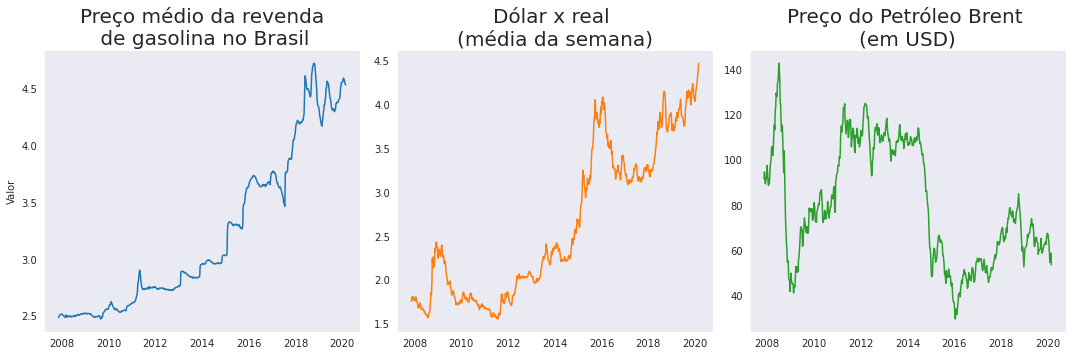

In [0]:
# Análise prévia dos dados

df1_ = df1.reset_index().melt(id_vars='index',
                             value_vars = ['preco_medio_revenda','cambio','close'],
                             var_name = 'medida', 
                             value_name = 'valor')

df1_['index'] = df1_['index'].apply(dt_from_week)
titles = {'cambio': 'Dólar x real \n(média da semana)', 
 'close': 'Preço do Petróleo Brent \n(em USD)', 
 'preco_medio_revenda': 'Preço médio da revenda\n de gasolina no Brasil'}

df1_['titulo'] = df1_.medida.map(titles)

g = sns.relplot(x="index", y="valor",
            col="titulo", hue='medida',
            facet_kws=dict(sharex=False, sharey=False),
            kind="line", data=df1_, legend=False)

g = (g.set_axis_labels('','Valor'))
g.set_titles('{col_name}', size=20)

g.savefig(png_path+'3.1a_.png')

## 3.2 Quando e como, aqui dentro

Comparar o preço da gasolina com os dados de inflação, especialmente a Cesta Básica e o Índice do IPCA. O problema é que o IPCA é um índice de variação, enquanto a cesta é um índice fixo. Talvez transformar um em outro.

In [0]:
# Dados para BH

filtroBH = df_ipca.abrangencia == 'BH'
cols = ['data','gasolina','indice geral']
sr_ipca = df_ipca[filtroBH][cols].set_index('data')

filtroBH = df_cesta.abrangencia == 'Belo Horizonte'
sr_cesta = df_cesta[filtroBH].set_index('data')['valor'].rename('cesta')

df2 = pd.concat([sr_ipca, sr_cesta], axis=1).dropna()

def adjusted_over_time(indices):
    return ((indices/100)+1).cumprod()

df2['gasolina_ajustada'] = adjusted_over_time(df2.gasolina)
df2['ipca_ajustado'] = adjusted_over_time(df2['indice geral'])

df2.to_csv(path+'/question2a.csv')

In [0]:
# Dados nacionais, sem o DIEESE

filtroBR = df_ipca.abrangencia == 'NACIONAL'
cols = ['data','gasolina','indice geral']
df2_b = df_ipca[filtroBR][cols].set_index('data')

df2_b['gasolina_ajustada'] = adjusted_over_time(df2_b.gasolina)
df2_b['ipca_ajustado'] = adjusted_over_time(df2_b['indice geral'])

df2_b.to_csv(path+'/question2b.csv')

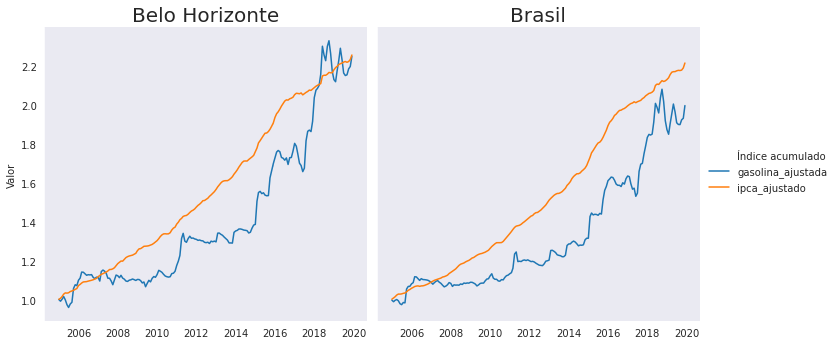

In [0]:
# Análise prévia dos dados

df2a = pd.read_csv('question2a.csv', parse_dates=['data'])
df2a['abrangencia'] = 'Belo Horizonte'

df2b = pd.read_csv('question2b.csv', parse_dates=['data'])
df2b['abrangencia'] = 'Brasil'

tb = pd.concat([df2a, df2b]).melt(
    id_vars = ['data', 'abrangencia'],
    value_vars = ['gasolina_ajustada','ipca_ajustado'],
    var_name = 'Índice acumulado',
    value_name = 'Valor'
)

g = sns.relplot(x="data", y="Valor",
            col="abrangencia", hue='Índice acumulado',
            # facet_kws=dict(sharex=False, sharey=False),
            kind="line", data=tb, legend='full')

g = (g.set_axis_labels('','Valor'))
g.set_titles('{col_name}', size=20)

g.savefig(png_path+'3.2a.png')

# 3.3 Quando e Onde, aqui dentro
Qual a geografia do preço dos preços de combustível a nível nacional, e em recortes regionais e estaduais?
 

In [0]:
cols = ['data_inicial', 'preco_medio_revenda',
       'regiao', 'estado', 'abrangencia']

df3 = df_ANPabrang[cols]

df3['data'] = df3['data_inicial'] + timedelta(days=3)

df3 = df3.drop('data_inicial', axis=1)

df3.to_csv(path + '/question3.csv', index=False)

g = sns.lineplot(x=df3.data.dt.year, 
                 y="preco_medio_revenda",
                hue='regiao',
                data=df3[df3.abrangencia == 'regional'],)

plt.xlabel("")
plt.ylabel("")
plt.title("Preço médio de revenda por região", size=20)

ylabels = ['R$ {:,.2f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)

names = [el.get_text().title() for el in g.axes.get_legend().texts]
for t, l in zip(g.axes.get_legend().texts, names): t.set_text(l)

plt.show(g)

# g.set(xlabel='', ylabel='')
# g = (g.set_axis_labels('','Valor'))
# g.set_titles('{col_name}', size=20)
# g.set_yscale("log")

g.figure.savefig(png_path+'3.3.png')

# 3.4 Onde e quanto, em Belo Horizonte
Quais os postos de combustível mais baratos na cidade, nas últimas semanas? E como os preços na cidade se comportam em relação à média estadual, nos últimos anos?


## Dados históricos, e a comparação com outros municípios

In [0]:
# Uma tabela de série histórica com os dados de BH, da média de Minas e da média nacional
filtro_bh = df_ANPmunici.municipio == 'BELO HORIZONTE'
cols = ['data_inicial', 'preço_medio_revenda',]

srBH = df_ANPmunici[filtro_bh][cols]
srBH['data'] = srBH['data_inicial'] + timedelta(days=3)
srBH['abrangencia'] = 'Belo Horizonte'
srBH.columns = ['data_inicial', 'preco_medio_revenda', 'data', 'abrangencia']

filtro_mg = df_ANPabrang.estado == 'MINAS GERAIS'
cols = ['data_inicial', 'preco_medio_revenda',]

srMG = df_ANPabrang[filtro_mg][cols]
srMG['data'] = srMG['data_inicial'] + timedelta(days=3)
srMG['abrangencia'] = 'Minas Gerais'

filtro_br = df_ANPabrang.abrangencia == 'nacional'
srBR = df_ANPabrang[filtro_br][cols]
srBR['data'] = srBR['data_inicial'] + timedelta(days=3)
srBR['abrangencia'] = 'Brasil'

df4a = pd.concat([srBH, srBR, srMG])
df4a = df4a.drop('data_inicial', axis=1)

df4a.to_csv(path + '/question4a.csv', index=False)

# Diferença em relação à média nacional
tb = df4a.pivot_table('preco_medio_revenda','data','abrangencia', 'sum')#.plot(kind='line')
# tb.subtract(tb['Brasil'], axis='index').plot()

# Uma tabela com a média, ano a ano, de BH e dos municípios da Grande BH
rmbh = [
        "Baldim", "Belo Horizonte", "Betim", "Brumadinho", "Caeté", "Capim Branco", 
        "Confins", "Contagem", "Esmeraldas", "Florestal", "Ibirité", "Igarapé", 
        "Itaguara", "Itatiaiuçu", "Jaboticatubas", "Nova União", "Juatuba", 
        "Lagoa Santa", "Mário Campos", "Mateus Leme", "Matozinhos", "Nova Lima", 
        "Pedro Leopoldo", "Raposos", "Ribeirão das Neves", "Rio Acima", "Rio Manso", 
        "Sabara", "Santa Luzia", "São Joaquim de Bicas", "São José da Lapa", 
        "Sarzedo", "Taquaraçu de Minas", "Vespasiano"
        ]
        
anp_munmg = set(df_ANPmunici.query('estado == "MINAS GERAIS"').municipio.unique())

mun_rmbh = {el.upper() for el in rmbh}
rmbh_anp =  mun_rmbh & anp_munmg

cols = ['data_inicial', 'preço_medio_revenda',]
filtro_rmbh = df_ANPmunici.municipio.isin(rmbh_anp)
srRMBH = df_ANPmunici[filtro_rmbh][cols + ['municipio']]
srRMBH['data'] = srRMBH['data_inicial'] + timedelta(days=3)

srRMBH = srRMBH.drop('data_inicial', axis=1)

srRMBH.to_csv(path + '/question4b.csv', index=False)

## Dados geográficos

In [0]:
# Usar os microdados
filtro = df_ANPpostos.combustivel == 'gasolina'
cols = ['razao', 'endereco', 'bairro', 'venda', 'data', 
        'combustivel', 'cidade', 'ix_semana']

df4c = df_ANPpostos[filtro][cols]

df4c.to_csv(path + '/question4c.csv', index=False)

Uma das utilidades dos dados de preço de combustível é poder ver, dentro da geografia da cidade, onde estão os postos com combustível a um preço mais acessível. Para isso, escrevi este script abaixo com o passo a passo da transformação de endereços em coordenadas.

In [0]:
# Usando a biblioteca geopy e a API de Encoding do Google Maps para processar os endereços

from geopy.geocoders import GoogleV3
geolocator = GoogleV3(api_key='google-maps-encoding-API')

# Construindo uma string com o endereço, o bairro, a cidade e o estado onde o posto fica
endereços = (df4c.endereco + ' ' + df4c.bairro + ', ' + df4c.cidade + ', MG').unique()

l = []

for endereço in endereços:
    try:
        # Aqui o dado é enviado para a API, retornando um objeto com as coordenadas
        l.append(geolocator.geocode(endereço))
    except:
        l.append(endereço)

# Os dados dos postos
enddf =  df4c[['razao','endereco','bairro','cidade']].drop_duplicates().reset_index(drop=True)

# DataFrame com os dados que precisamos, usando os pontos como base
geodf = pd.DataFrame([(el.address, el.longitude, el.latitude) for el in l], columns=['endereço','longitude','latitude'])

# Gravando um CSV para poder observar os pontos no Google Maps
pd.concat([enddf, geodf], axis=1).to_csv('endereços_postos.csv', index=False)

Agora, unindo os dados de preços com a tabela acima, e exportando um CSV para poder ser importe no Google Maps

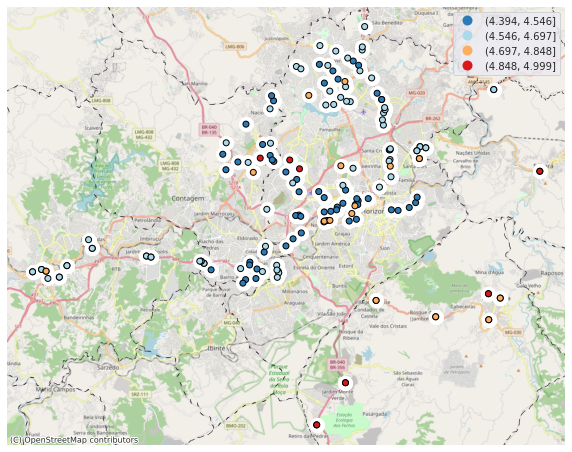

In [0]:
if not 'palettable' in globals().keys():
    !pip install palettable
    import palettable

if not 'ctx' in globals().keys():
    !pip install contextily
    import contextily as ctx

if not 'geopandas' in globals().keys():
    !pip install geopandas
    import geopandas

cmap = palettable.colorbrewer.diverging.RdYlBu_4_r

path = "/content/drive/My Drive/EAD/PUC Minas/13 - TCC/data/shapefile/31MUE250GC_SIR.shp"

GEOmg = geopandas.read_file(path)

path = '/content/drive/My Drive/EAD/PUC Minas/13 - TCC/data/Postos de BH.kml'

# Ler os dados do kml
geopandas.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

GEOdf = geopandas.read_file(path)
GEOdf['endereco'] = GEOdf.Description.str.extract(' *endereco: ([^\<]+)')


# Dados das ultimas duas semanas
f = df4c.ix_semana.isin(sorted(df4c.ix_semana.unique())[-2:])

GEOdf = GEOdf.merge(df4c[f], left_on = ('Name','endereco'), right_on = ('razao','endereco'))

GEOdf['quantile'] = pd.cut(GEOdf.venda, 4)


fig, ax = plt.subplots(figsize=(10,10))

GEOdf = GEOdf.to_crs(epsg=3857)
GEOmg = GEOmg.to_crs(epsg=3857)

base_white = GEOdf.plot(ax=ax, alpha=1, edgecolor='white',
                    facecolor='white', markersize=200, zorder=1.0)


ax_ = GEOdf.plot(ax=ax, alpha=1, edgecolor='k', 
                column = 'quantile', cmap=cmap.mpl_colormap, legend=True,
                linewidths=(1,), zorder=1.5)

xlim = ax.axes.get_xlim()
ylim = ax.axes.get_ylim()

cities = GEOmg.plot(ax=ax, facecolor='none', 
                    edgecolor='0.25', lw=0.7, zorder=0.5,
                    linestyle = (0,(5,10)))

ax.axes.set_xlim(xlim)
ax.axes.set_ylim(ylim)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

(-2283845.1080217287, -2246356.5865386697)

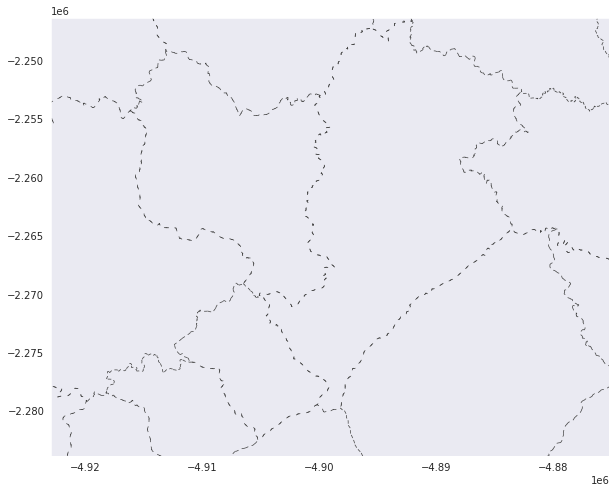

In [0]:
# Ler os municípios
fig, ax = plt.subplots(figsize=(10,10))

cities = GEOmg.plot(ax=ax, facecolor='none', 
                    edgecolor='0.25', lw=0.7, zorder=0.5,
                    linestyle = (0,(5,10)))

ax.axes.set_xlim(xlim)
ax.axes.set_ylim(ylim)